New:
 - Possible MVA added

In [1]:
fit_real_data = False
category = ['low', 'mid', 'high'][2]
SM_RDst = 0.33
runCombine = False
runBias = False
runImpacts = True
useMVA = 1
card_name = 'v10'

In [2]:
if not fit_real_data: card_name += 'Asimov'
card_name += '_' + category
outdir = 'results/' + card_name
card_location = 'cards/{}.txt'.format(card_name)

# Import

In [3]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
import itertools
import commands
from prettytable import PrettyTable
import json, yaml
from IPython.display import IFrame, Image, display

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from progressBar import ProgressBar
from lumi_utilities import getLumiByTrigger
from combine_utilities import getUncertaintyFromLimitTree, dumpDiffNuisances, stringJubCustomizationCaltechT2

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [5]:
cat = categories[category]

# Load the datasets

In [6]:
#They all have to be produced with the same pileup
MCsample = {
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
processOrder = ['tau', 'mu', 'DstPip','DstPi0','DstPipPi0','DstPipPim','DstPi0Pi0','DstmDsp','DstmD0','DstmDp','BpDstmHc','BmDstmHc','antiB0DstmHc']
dSet = {}
dSetTkSide = {}
for n, s in MCsample.iteritems():
    if not n in processOrder: raise
    dSet[n] = rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name))
    dSetTkSide[n] = rtnp.root2array(s.skimmed_dir + '/{}_trkCtrl_corr.root'.format(cat.name))

In [7]:
if fit_real_data:
    creation_date = '200515'
    locRD = '../data/cmsRD/skimmed/B2DstMu_B0_{}_{}'.format(creation_date, cat.name)
    dSet['data'] = rtnp.root2array(locRD + '_corr.root')
    dSetTkSide['data'] = rtnp.root2array(locRD + '_trkCtrl_corr.root')
    dataDir = '../data/cmsRD'
    datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_{}_CAND.root'.format(creation_date))
    lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
    CMS_lumi.integrated_lumi = lumi_tot
else:
    expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4, 'single':6.} #fb^-1
    lumi_tot = expectedLumi[category]

# Load all the calibrations

Pileup

In [8]:
from pileup_utilities import pileupReweighter
puReweighter = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), cat)

Branching fraction

In [9]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

Trigger scale factor

In [10]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

In [11]:
def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
    ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
    etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
    x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta, ip) in enumerate(x):
        ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
        iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
        iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
        trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
        ib = hTriggerSF.GetBin(ix, iy, iz)
        trgSFUnc[i] = hTriggerSF.GetBinError(ib)
        if trgSF[i] == 0:
            print pt, ip, np.abs(eta)
            raise
    # Divide them for the weight so later you can simply multiply back to get the value
    up = 1 + trgSFUnc/trgSF
    down = 1 - trgSFUnc/trgSF
    return trgSF, up, down

Muon ID scale factors

In [12]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

In [13]:
def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
    etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
    x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta) in enumerate(x):
        ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
        if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
        iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
        muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
        muonSFUnc[i] = hMuonIDSF.GetBinError(hMuonIDSF.GetBin(ix, iy))
        if muonSF[i] == 0:
            print pt, eta
            print ix, iy
            raise
    up = 1 + muonSFUnc/muonSF
    down = 1 - muonSFUnc/muonSF
    return muonSF, up, down

B transverse momentum calibration

In [14]:
aux = 'Low' if category == 'single' else cat.name
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(aux))

In [15]:
def computeB0pTweights(ds):
    # The denominator (sum of weights) for this weights is not known but it cancel out in the ratio
    w = cal_pT.f['C'](ds['MC_B_pt'])
    if np.sum(w==0):
        print np.sum(w==0)
        raise
    up = cal_pT.f['Up'](ds['MC_B_pt'])/w
    down = cal_pT.f['Down'](ds['MC_B_pt'])/w
    return w, up, down

In [16]:
def computeBrVarWeights(ds, selItems={}, relScale=0.2, keepNorm=False):
    sel = np.ones_like(ds['mu_pt']).astype(np.bool)
    for var, val in selItems.iteritems():
        sel = np.logical_and(ds[var].astype(np.int) == val, sel)
    w = np.ones_like(sel)
    up = np.where(sel, 1.+relScale, 1.)
    down = np.where(sel, max(0, 1.-relScale), 1.)
    if keepNorm:
        up = float(up.shape[0])/np.sum(up)
        down = float(down.shape[0])/np.sum(down)
    return w, up, down

In [17]:
def computeTksPVweights(ds, relScale=0.05, centralVal=0.39/0.10):
    selPdgID0 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_0']) < 6, ds['MC_tkMotherPdgId_0'] != 0)
    selPdgID0 = np.logical_or(selPdgID0, ds['MC_tkMotherPdgId_0']==2212)
    selPdgID0 = np.logical_and(selPdgID0, ds['MC_tkFlag_0'] == 1)
    selPdgID1 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_1']) < 6, ds['MC_tkMotherPdgId_1'] != 0)
    selPdgID1 = np.logical_or(selPdgID1, ds['MC_tkMotherPdgId_1']==2212)
    selPdgID1 = np.logical_and( selPdgID1, ds['MC_tkFlag_1'] == 1)
    exponent = selPdgID0.astype(np.int) + selPdgID1.astype(np.int)
    w = np.power(centralVal, exponent)
    up = np.power(centralVal*(1+relScale), exponent)/w
    down = np.power(centralVal*(1-relScale), exponent)/w
    return w, up, down

MVA

In [18]:
fname = '../plot_scripts/kinObsMVA/clfGBC_tauVall_v0{}.p'.format(cat.name)
clfGBC = pickle.load(open(fname, 'rb'))

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.4 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.20.4 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [19]:
def computeVarMVA(ds):
    aux = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss']))
    p = clfGBC.predict_proba(aux)
    return p[:,1]

# Create MC histograms

In [20]:
histo = {}
eventCountingStr = {}

### Signal region

In [21]:
binning = {
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, -0.2, 0.4)) + [-0.2, 0., 0.2, 0.6, 8] ),
        array('d', [-2.5] + list(np.arange(-1.8, -0.1, 0.4)) + [-0.1, 0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.0, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.6, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
    ],
    'Est_mu'  : [
        array('d', [0.3] + list(np.arange(0.7, 2.3, 0.1)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.7, 2.5, 0.1)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.1)) + [2.5] ),
        [22, 0.3, 2.500],
    ],
}
if fit_real_data:
    binning['q2'] = array('d', [-2, 2.5, 6])
else:
    binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])
    
binning['MVA'] = array('d', list(np.arange(0., 0.81, 0.04)))

In [22]:
totalCounting = [0,0]
for n in processOrder:
    ds = dSet[n]
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    totalCounting[1] += 1e-3*nTotSelected
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot# * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.2f}k'.format(1e-3*nTotExp)
    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
    print 'Including trigger corrections'
    weights['trg{}SF'.format(cat.trg)], wVar['trg{}SFUp'.format(cat.trg)], wVar['trg{}SFDown'.format(cat.trg)] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'DstmD0', 'DstmDp', 'DstmDsp','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'eig1', 'eig2', 'eig3']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + tag]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    #Dstst resonance mix
    if n == 'DstPip':
        _, wVar['fDststWideUp'], wVar['fDststWideDown'] = computeBrVarWeights(ds, {'MC_munuSisterPdgId': -20423}, 0.6/2.7, keepNorm=True) #Gamma 14 pdg 2020
    #Hc mix variations
    if n == 'DstmD0':
        _, wVar['BrB02DstD0KpUp'], wVar['BrB02DstD0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 321}, 0.21/2.47) #Gamma 169 pdg 2020
        _, wVar['BrB02DstD0KstpUp'], wVar['BrB02DstD0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDst0KpUp'], wVar['BrB02DstDst0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 321}, 0.09/1.06) #Gamma 170 pdg 2020
        _, wVar['BrB02DstDst0KstpUp'], wVar['BrB02DstDst0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.5/5.3) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDp':
        _, wVar['BrB02DstDpK0Up'], wVar['BrB02DstDpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 311}, 0.5/3.2) #Gamma 172 pdg 2020
        _, wVar['BrB02DstDpKst0Up'], wVar['BrB02DstDpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.2/2.7) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDsp':
        _, wVar['BrB02DstDsUp'], wVar['BrB02DstDsDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 431}, 1.1/8.0) #Gamma 83 pdg 2020
        _, wVar['BrB02DstDsstUp'], wVar['BrB02DstDsstDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 433}, .14/1.77) #Gamma 85 pdg 2020
        _, wVar['BrB02DstDs0stUp'], wVar['BrB02DstDs0stDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 10431}, .6/1.5) #Gamma 95 pdg 2020
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): weightsCentral *= w
    print 'N tot expected (after weights): {:.3f}k'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected)
    totalCounting[0] += 1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected
    evCountStr = '{:.2f} ({:.2f})'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected, 1e-3*nTotSelected)
    eventCountingStr[n] = evCountStr
    wVar[''] = np.ones_like(weightsCentral)
    
    
    if useMVA:
        print 'Evaluating MVA'
        if not 'MVA' in histo.keys():
            histo['MVA'] = {}
        sMVA = computeVarMVA(ds)
        for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo['MVA'][h_name] = create_TH1D(sMVA, name=h_name, weights=w, scale_histo=scale,
                                                   binning=binning['MVA'], opt='underflow,overflow')
    
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            if not cat_name in histo.keys():
                histo[cat_name] = {}
            
            for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo[cat_name][h_name] = create_TH1D(
                                                      ds[var][sel_q2], 
                                                      name=h_name, title=h_name, 
                                                      binning=binning[var][i_q2], 
                                                      opt='underflow,overflow',
                                                      weights=w[sel_q2], scale_histo=scale,
                                                      )
                
evCountStr = '{:.1f} ({:.1f})'.format(*totalCounting)
eventCountingStr['tot'] = evCountStr


-----------> tau <-------------
N tot selected: 29.6k
N tot expected (before weights): 4.62k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 4.975k
Evaluating MVA

-----------> mu <-------------
N tot selected: 495.6k
N tot expected (before weights): 155.95k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 159.927k
Evaluating MVA

-----------> DstPip <-------------
N tot selected: 17.7k
N tot expected (before weights): 3.05k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Computing total weights
N tot expected (after weights): 3.174k
Evaluating MVA

-----------> DstPi0 <-------------
N tot selected: 34.2k
N tot expected (before weigh

### Single track side

In [23]:
sideSelecton = {}
sideVar = {}
sideXtitle = {}
sideAddtext = {}

def selfun__TkPlus(ds):
    sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] > 0)
    return sel
#     return np.logical_and(np.abs(ds['tkMassHad_0'] - 2.43) < 0.3, sel)
sideSelecton['AddTk_p_mHad'] = selfun__TkPlus
sideVar['AddTk_p_mHad'] = 'tkMassHad_0'
binning['AddTk_p_mHad'] = [35, 2.13, 2.83]
sideXtitle['AddTk_p_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_p_mHad'] = 'N_{tk} = 1 & Q_{tk} = +1'

def selfun__TkMinus(ds):
    sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] < 0)
    return sel
sideSelecton['AddTk_m_mHad'] = selfun__TkMinus
sideVar['AddTk_m_mHad'] = 'tkMassHad_0'
binning['AddTk_m_mHad'] = [30, 2.1, 3.3]
sideXtitle['AddTk_m_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_m_mHad'] = 'N_{tk} = 1 & Q_{tk} = -1'

# sideSelecton['AddTk_m_tkPt'] = selfun__TkMinus
# sideVar['AddTk_m_tkPt'] = 'tkPt_0'
# binning['AddTk_m_tkPt'] = np.logspace(np.log10(0.5), np.log10(5.0), 30)
# sideXtitle['AddTk_m_tkPt'] = 'Additional track p_{T}'
# sideAddtext['AddTk_m_tkPt'] = 'N_{tk} = 1 & Q_{tk} = -1'


def selfun__TkPlusMinus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == 0, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['tkMassVis12'] < 5.3, sel)
    return sel
sideSelecton['AddTk_pm_mVis'] = selfun__TkPlusMinus
sideVar['AddTk_pm_mVis'] = 'tkMassVis12'
binning['AddTk_pm_mVis'] = array('d', [2.8] + list(np.arange(3., 5.3, 0.1)) + [5.3] )
sideXtitle['AddTk_pm_mVis'] = 'Total visible mass'
sideAddtext['AddTk_pm_mVis'] = 'N_{tk} = 2 & #sumQ_{tk} = 0'


sideSelecton['AddTk_pm_mHad'] = selfun__TkPlusMinus
sideVar['AddTk_pm_mHad'] = 'tkMassHad12'
binning['AddTk_pm_mHad'] = [30, 2.3, 3.75]
sideXtitle['AddTk_pm_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_pm_mHad'] = 'N_{tk} = 2 & #sumQ_{tk} = 0'

def selfun__TkMinusMinus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == -2, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['tkMassVis12'] < 5.3, sel)
    return sel
sideSelecton['AddTk_mm_mHad'] = selfun__TkMinusMinus
sideVar['AddTk_mm_mHad'] = 'tkMassHad12'
binning['AddTk_mm_mHad'] = [15, 2.25, 3.6]
sideXtitle['AddTk_mm_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_mm_mHad'] = 'N_{tk} = 2 & #sumQ_{tk} = -2'

def selfun__TkPlusPlus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == +2, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['tkMassVis12'] < 5.3, sel)
    return sel
sideSelecton['AddTk_pp_mHad'] = selfun__TkPlusPlus
sideVar['AddTk_pp_mHad'] = 'tkMassHad12'
binning['AddTk_pp_mHad'] = [15, 2.25, 3.75]
sideXtitle['AddTk_pp_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_pp_mHad'] = 'N_{tk} = 2 & #sumQ_{tk} = +2'

In [24]:
for k in sideSelecton.keys():
    histo[k] = {}

totalCounting = {}
for n in processOrder:
    ds = dSetTkSide[n]
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
#     weights['pileup'] = getPileupWeights(ds)
    print 'Including trigger corrections'
    weights['trg{}SF'.format(cat.trg)], wVar['trg{}SFUp'.format(cat.trg)], wVar['trg{}SFDown'.format(cat.trg)] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'DstmD0', 'DstmDp', 'DstmDsp','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'eig1', 'eig2', 'eig3']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + tag]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    #Dstst resonance mix
    if n == 'DstPip':
        _, wVar['fDststWideUp'], wVar['fDststWideDown'] = computeBrVarWeights(ds, {'MC_munuSisterPdgId': -20423}, 0.6/2.7, keepNorm=True) #Gamma 14 pdg 2020
    #Hc mix variations
    if n == 'DstmD0':
        _, wVar['BrB02DstD0KpUp'], wVar['BrB02DstD0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 321}, 0.21/2.47) #Gamma 169 pdg 2020
        _, wVar['BrB02DstD0KstpUp'], wVar['BrB02DstD0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDst0KpUp'], wVar['BrB02DstDst0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 321}, 0.09/1.06) #Gamma 170 pdg 2020
        _, wVar['BrB02DstDst0KstpUp'], wVar['BrB02DstDst0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.5/5.3) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDp':
        _, wVar['BrB02DstDpK0Up'], wVar['BrB02DstDpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 311}, 0.5/3.2) #Gamma 172 pdg 2020
        _, wVar['BrB02DstDpKst0Up'], wVar['BrB02DstDpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.2/2.7) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDsp':
        _, wVar['BrB02DstDsUp'], wVar['BrB02DstDsDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 431}, 1.1/8.0) #Gamma 83 pdg 2020
        _, wVar['BrB02DstDsstUp'], wVar['BrB02DstDsstDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 433}, .14/1.77) #Gamma 85 pdg 2020
        _, wVar['BrB02DstDs0stUp'], wVar['BrB02DstDs0stDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 10431}, .6/1.5) #Gamma 95 pdg 2020
        
    # Correct the amount of random tracks from PV
    weights['tkPVfrac'], wVar['tkPVfracUp'], wVar['tkPVfracDown'] = computeTksPVweights(ds)
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): 
        weightsCentral *= w
    wVar[''] = np.ones_like(weightsCentral)
    
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot# * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], 
                  decayBR[n], 
                  sMC.effCand['effCAND'], 
                  sMC.getSkimEff(cat.name+'_trkCtrl_corr'),
                 ]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    
    sel = {}
    scale = {}
    
    latexTableString = {}
    for k, selFun in sideSelecton.iteritems():
        sel[k] = selFun(ds)
        nTotSel = float(np.sum(sel[k]))
        print 'N tot selected {}: {:.0f}'.format(k, nTotSel)
        nExp = nTotExp * nTotSel / sel[k].shape[0]
        print 'N tot expected {} (before weights): {:.0f}'.format(k, nExp)
        nAux = nTotExp * np.sum(weightsCentral[sel[k]]) / sel[k].shape[0]
        print 'N tot expected {} (after weights): {:.0f}'.format(k, nAux)
        latexTableString[k] = '{:.0f} ({:.0f})'.format(nAux, nTotSel)
        if not k in totalCounting.keys():
            totalCounting[k] = [0, 0]
        totalCounting[k][0] += nAux
        totalCounting[k][1] += nTotSel
        if nTotSel ==0: 
            nTotSel+=1
        scale[k] = nExp/nTotSel
    s = ' & '.join([latexTableString['AddTk_'+s+'_mHad'] for s in ['p', 'm', 'pp', 'pm', 'mm']])
    print s
    eventCountingStr[n] += ' & ' + s + '\\\\'
    
            
    for name_wVar, v_wVar in wVar.iteritems():
        h_name = n
        if not name_wVar == '':
            h_name += '__' + name_wVar
        w = weightsCentral*v_wVar
        
        for k in sideVar.keys():
            histo[k][h_name] = create_TH1D(
                                           ds[sideVar[k]][sel[k]], 
                                           name=h_name, title=h_name, 
                                           binning=binning[k],
                                           opt='underflow',
                                           weights=w[sel[k]], scale_histo=scale[k]
                                          )
            
s = ' & '.join(['{:.0f} ({:.0f})'.format(*totalCounting['AddTk_'+s+'_mHad']) for s in ['p', 'm', 'pp', 'pm', 'mm']]) + ' \\\\'
eventCountingStr['tot'] += ' & ' + s


-----------> tau <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot selected AddTk_pm_mHad: 34
N tot expected AddTk_pm_mHad (before weights): 5
N tot expected AddTk_pm_mHad (after weights): 13
N tot selected AddTk_m_mHad: 643
N tot expected AddTk_m_mHad (before weights): 100
N tot expected AddTk_m_mHad (after weights): 149
N tot selected AddTk_p_mHad: 721
N tot expected AddTk_p_mHad (before weights): 112
N tot expected AddTk_p_mHad (after weights): 183
N tot selected AddTk_pp_mHad: 16
N tot expected AddTk_pp_mHad (before weights): 2
N tot expected AddTk_pp_mHad (after weights): 5
N tot selected AddTk_mm_mHad: 18
N tot expected AddTk_mm_mHad (before weights): 3
N tot expected AddTk_mm_mHad (after weights): 5
N tot selected AddTk_pm_mVis: 34
N tot expected AddTk_pm_mVis (before weights): 5
N tot expected AddTk_pm_mVis (after weights): 13
183 (7

Including B0 pT corrections
Computing total weights
N tot selected AddTk_pm_mHad: 894
N tot expected AddTk_pm_mHad (before weights): 69
N tot expected AddTk_pm_mHad (after weights): 79
N tot selected AddTk_m_mHad: 187
N tot expected AddTk_m_mHad (before weights): 14
N tot expected AddTk_m_mHad (after weights): 17
N tot selected AddTk_p_mHad: 549
N tot expected AddTk_p_mHad (before weights): 42
N tot expected AddTk_p_mHad (after weights): 49
N tot selected AddTk_pp_mHad: 15
N tot expected AddTk_pp_mHad (before weights): 1
N tot expected AddTk_pp_mHad (after weights): 1
N tot selected AddTk_mm_mHad: 4
N tot expected AddTk_mm_mHad (before weights): 0
N tot expected AddTk_mm_mHad (after weights): 1
N tot selected AddTk_pm_mVis: 894
N tot expected AddTk_pm_mVis (before weights): 69
N tot expected AddTk_pm_mVis (after weights): 79
49 (549) & 17 (187) & 1 (15) & 79 (894) & 1 (4)

-----------> DstmDp <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID co

# Create (pseudo-)data histogram

In [25]:
if fit_real_data:
    ds = dSet['data']
    print 'N observed data signal region: {:.1f}k'.format(1e-3*ds['q2'].shape[0])
    if useMVA:
        print 'Evaluating MVA'
        sMVA = computeVarMVA(ds)
        histo['MVA']['data'] = create_TH1D(sMVA, name='data_obs', binning=binning['MVA'], opt='underflow,overflow')
                
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)     
            histo[cat_name]['data'] = create_TH1D(
                                                  ds[var][sel_q2], 
                                                  name='data_obs', title='Data Obs',
                                                  binning=binning[var][i_q2],
                                                  opt='underflow,overflow'
                                                 )
    ds = dSetTkSide['data']
    for k in sideVar.keys():
        histo[k]['data'] = create_TH1D(
                                       ds[sideVar[k]][sideSelecton[k](ds)], 
                                       name='data_obs', title='Data Obs', 
                                       binning=binning[k],
                                       opt='underflow',
                                      )
    print 'N observed data control regions: ' + ' & '.join(['{:.0f}'.format(histo['AddTk_'+s+'_mHad']['data'].Integral()) for s in ['p', 'm', 'pp', 'pm', 'mm']]) + ' \\\\'
        
else:
    if useMVA:
        h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning['MVA'])
        h.Reset()
        for n, hMC in histo['MVA'].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
        h.Sumw2(0)
        for i in range(1, h.GetNbinsX()+1):
            h.SetBinContent(i, np.around(h.GetBinContent(i)))
        h.Sumw2()
        histo['MVA']['data'] = h
    for i_q2 in range(len(binning['q2'])-1):
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning[var][i_q2])
            h.Reset()
            for n, hMC in histo[cat_name].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
            h.Sumw2(0)
            for i in range(1, h.GetNbinsX()+1):
                h.SetBinContent(i, np.around(h.GetBinContent(i)))
            h.Sumw2()
            histo[cat_name]['data'] = h
            
    for k in sideVar.keys():
        h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', 
                        binning=binning[k])
        h.Reset()
        for n, hMC in histo[k].iteritems():
            if not '__' in n and not n == 'data':
                scale = SM_RDst if 'tau' in n else 1.
                h.Add(hMC, scale)
        h.Sumw2(0)
        for i in range(1, h.GetNbinsX()+1):
            h.SetBinContent(i, np.around(h.GetBinContent(i)))
        h.Sumw2()
        histo[k]['data'] = h

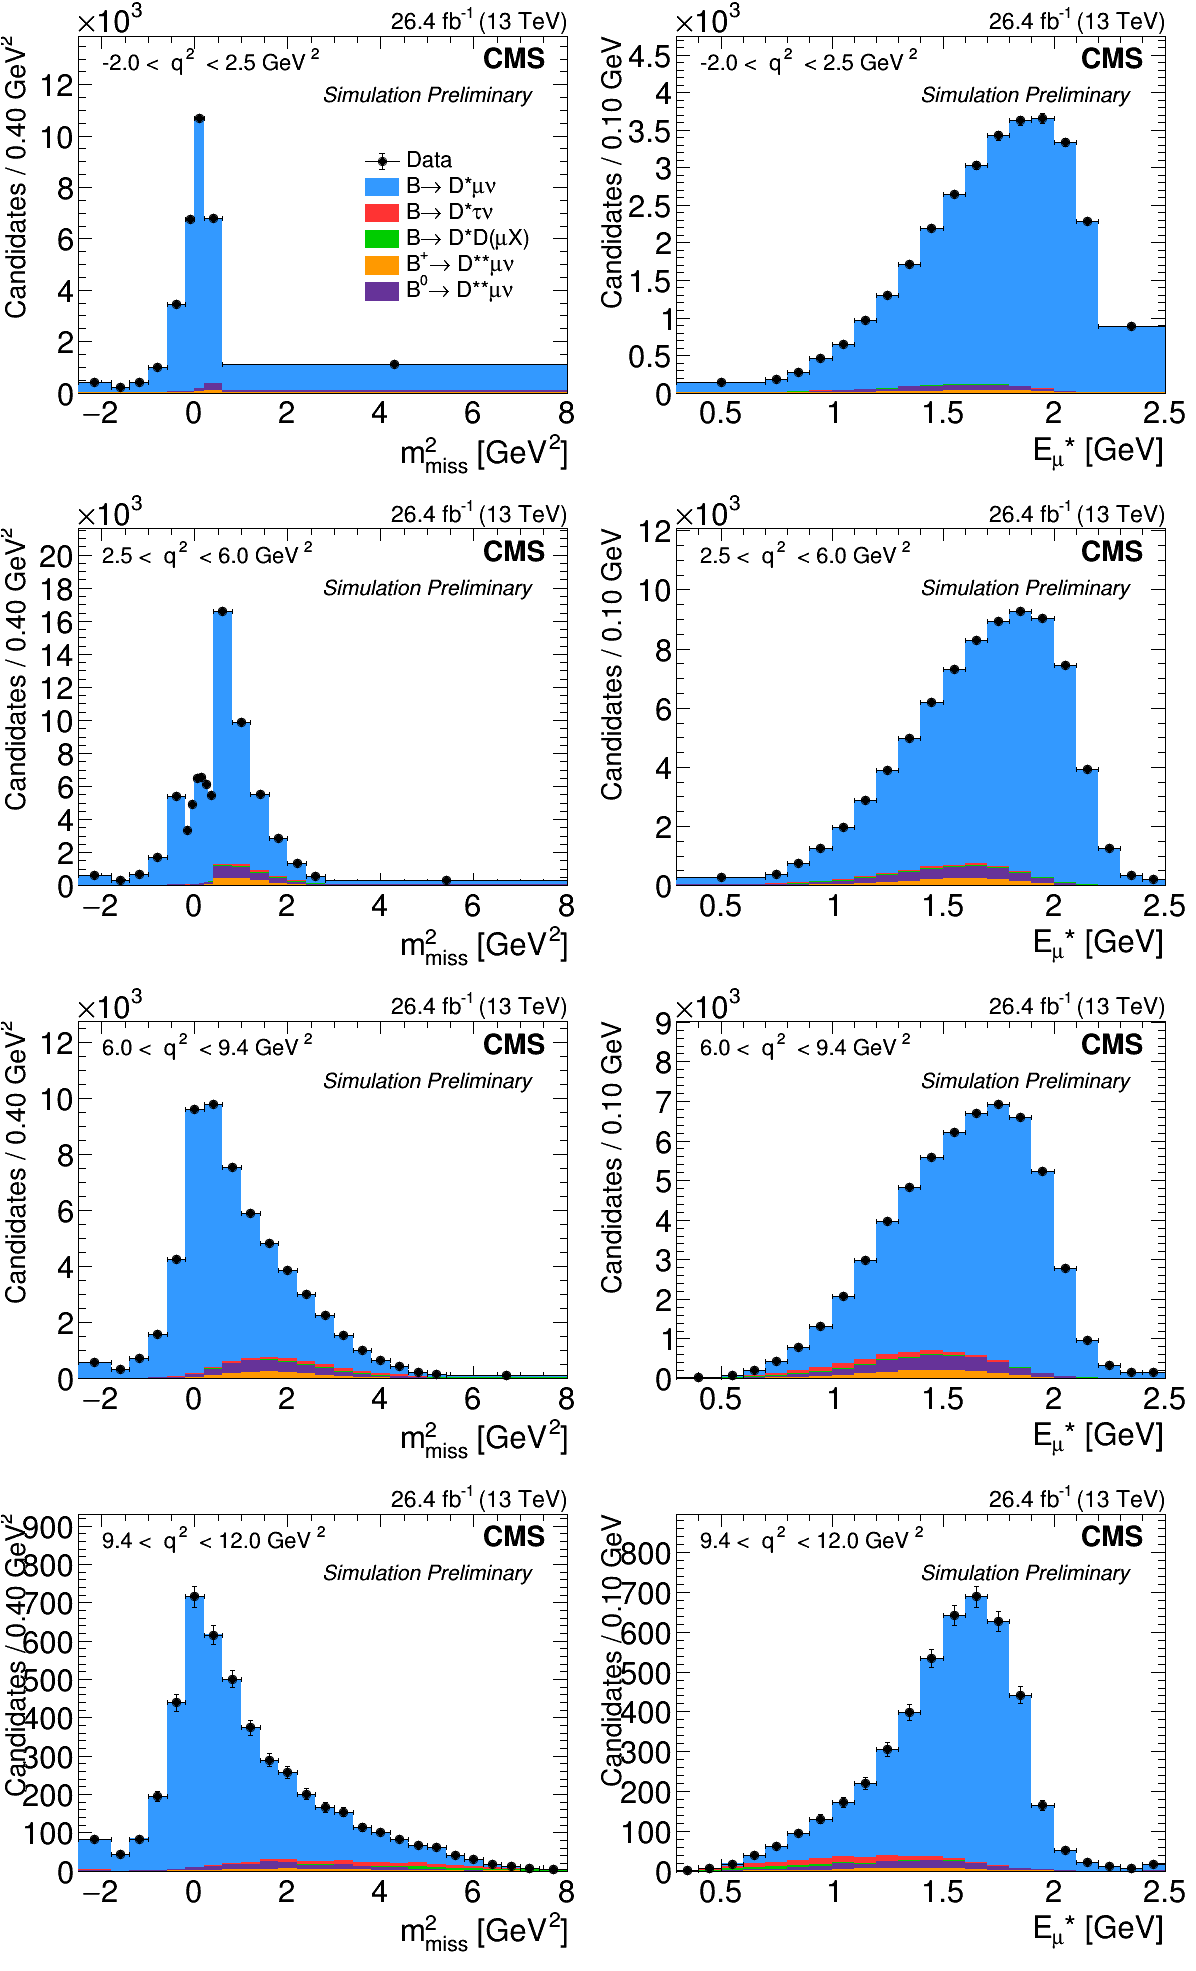

In [26]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {'tau': SM_RDst}

cSigPre = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic=scale_dic, min_y=0, logy=False)

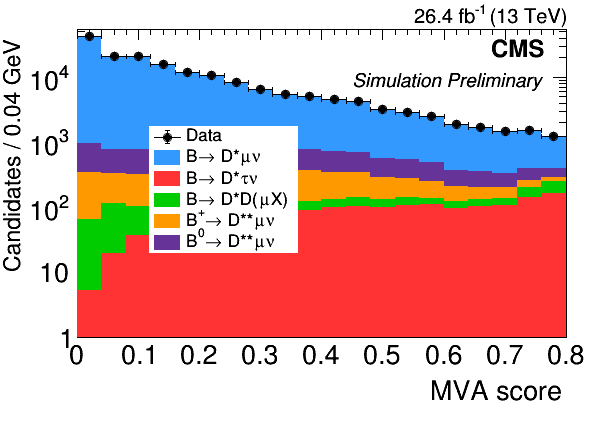

In [27]:
if useMVA:
    histo['MVA']['data'].GetXaxis().SetTitle('MVA score')
    cMVAPre = plot_SingleCategory(CMS_lumi, histo['MVA'], scale_dic=scale_dic,
                                  addText='', logy=True, legBkg=True,
                                  procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                  min_y=1, tag='MVA', legLoc=[0.25, 0.4, 0.5, 0.7])

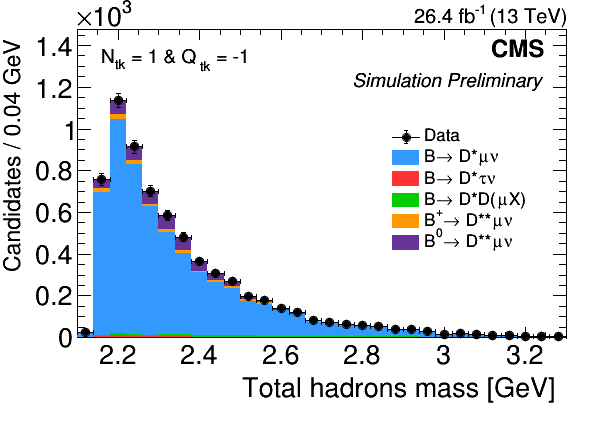

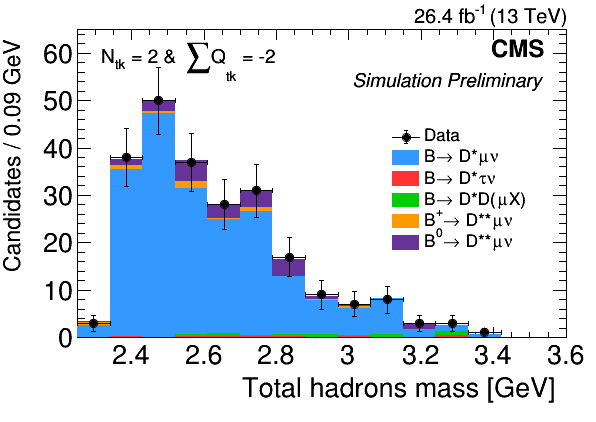

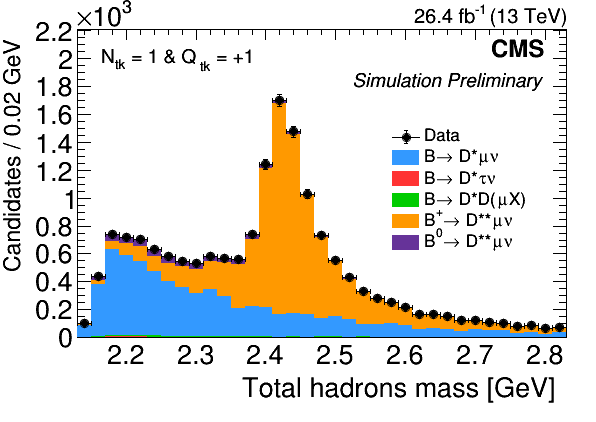

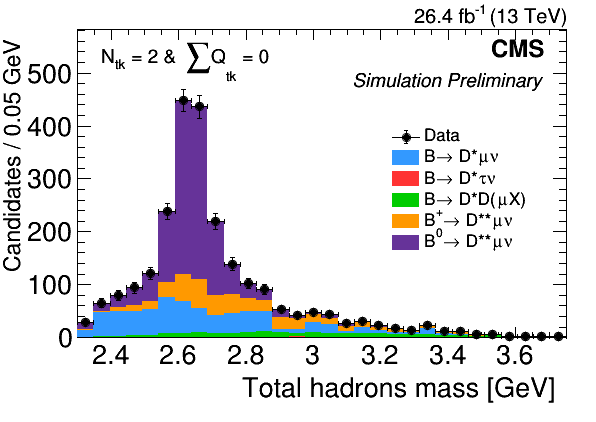

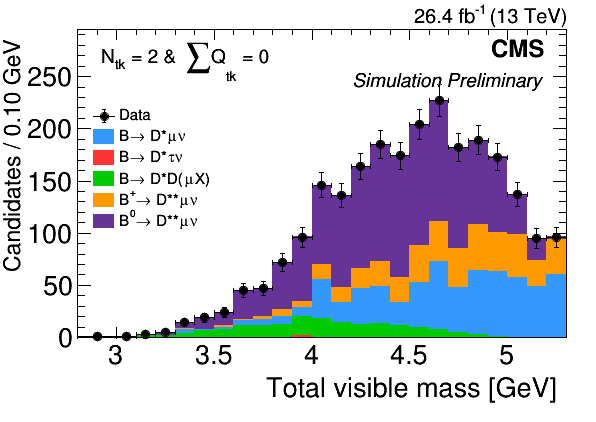

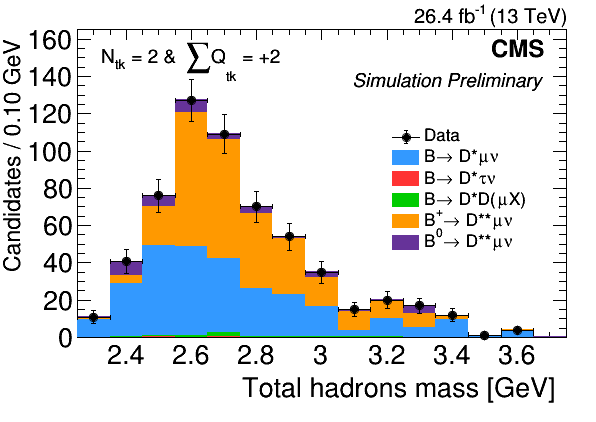

In [28]:
cSidePre = {}
for k in np.sort(sideVar.keys()):
    legLoc = [0.65, 0.4, 0.9, 0.7]
    if 'MassVis' in sideVar[k]:
        legLoc = [0.15, 0.45, 0.35, 0.75]
    cSidePre[k] = plot_SingleCategory(CMS_lumi, histo[k], scale_dic=scale_dic,
                                      xtitle=sideXtitle[k], addText=sideAddtext[k], 
                                      min_y=0, tag=k, legLoc=legLoc)

In [29]:
histo_file_dir = '/storage/user/ocerri/BPhysics/data/_root/histos4combine/'
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()
    
del dSet, dSetTkSide

# Write the card

In [30]:
sig_processes = ['tau', 'mu']
bkg_processes = ['DstmD0', 'DstmDp', 'DstmDsp', 
                 'BpDstmHc', 'BmDstmHc', 'antiB0DstmHc',
                 'DstPip', 'DstPipPi0', 
                 'DstPi0', 'DstPipPim', 'DstPi0Pi0']
processes = sig_processes + bkg_processes
nProc = len(processes)
categories = np.sort([k for k in histo.keys()])
nCat = len(categories)

In [31]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += 60*'-'+'\n'

In [32]:
# shape file location
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += 60*'-'+'\n'

### Number of events

In [33]:
# number of events observed
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += 60*'-'+'\n'

In [34]:
# MC expected events
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {:.2f}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += 60*'-'+'\n'

## Systematic uncertainties

### Scale systematics

In [35]:
#pp -> bb cros-section * luminosity
card += 'xsecpp2bbXlumi lnN' + ' 1.5'*nProc*nCat + '\n'

In [36]:
#Hadronization fraction of B0
aux = ''
for n in processes:
    if n in ['tau', 'mu', 'DstmD0', 'DstmDp', 'DstmDsp', 'DstPi0', 'DstPipPim', 'DstPi0Pi0', 'antiB0DstmHc']: 
        aux += ' 1.3'
    else: aux += ' -'
card += 'b2B0Had lnN' + aux*nCat + '\n'

In [37]:
#Hadronization fraction of B+
aux = ''
for n in processes:
    if n in ['DstPip', 'DstPipPi0', 'BpDstmHc', 'BmDstmHc']: aux += ' 1.3'
    else: aux += ' -'
card += 'b2BpHad lnN' + aux*nCat + '\n'

In [38]:
# Branching ratio uncertainty
for n in processes:
    if n in ['tau', 'DstPip', 'DstPi0', 'DstPipPim', 'DstPipPi0', 'DstPi0Pi0']: continue
#     if n in ['tau', 'DstPip', 'DstPi0', 'DstPipPim', 'DstPipPi0', 'DstPi0Pi0', 'BmDstmHc']: continue
    val = ' {:.2f}'.format(1+decayBR[n][1]/decayBR[n][0])
    aux = ''
    for nn in processes:
        if nn == n: aux += val
        else: aux += ' -'
    card += n + 'Br lnN' + aux*nCat + '\n'

In [39]:
# Branching ration uncertainty with isospin symmetry constraint
val = ' {:.2f}'.format(1+decayBR['DstPip'][1]/decayBR['DstPip'][0]) #DstPi0 has no info
aux = ''
for n in processes:
    if n in ['DstPip', 'DstPi0']: aux += val
    else: aux += ' -'
card += 'DstPiBr lnN' + aux*nCat + '\n'

val = ' {:.2f}'.format(1+decayBR['DstPipPim'][1]/decayBR['DstPipPim'][0]) #DstPipPim is the only one meaasured
aux = ''
for n in processes:
    if n in ['DstPipPim', 'DstPipPi0', 'DstPi0Pi0']: aux += val
    else: aux += ' -'
card += 'DstPiPiBr lnN' + aux*nCat + '\n'

In [40]:
card += 60*'-'+'\n'

### Shape Systematics

In [41]:
card += 'trg{}SF shape'.format(cat.trg) + ' 1.'*nProc*nCat + '\n'

In [42]:
card += 'muonIdSF shape' + ' 1.'*nProc*nCat + '\n'

In [43]:
aux = ''
for cat in categories:
    if cat.startswith('AddTk_'):
        aux += ' 1.'*nProc
    else: aux += ' -'*nProc
card += 'tkPVfrac shape' + aux + '\n'

In [44]:
# B0 pT spectrum
aux = ''
for p in processes:
    if p in ['tau', 'mu', 'DstmD0', 'DstmDp', 'DstmDsp', 'DstPi0', 'DstPipPim', 'DstPi0Pi0']:
        aux += ' 1.'
    else:
        aux += ' -'
card += 'B0pT shape' + aux*nCat + '\n'

In [45]:
# Form Factors from Hammer
for n_pFF in ['R0', 'eig1', 'eig2', 'eig3']:
    aux = ''
    for p in processes:
        if p in ['tau', 'mu']:
            aux += ' 1.'
        else:
            aux += ' -'
    card += 'B2DstCLN{} shape'.format(n_pFF) + aux*nCat + '\n'

In [46]:
# Dstst mix composition
aux = ''
for p in processes:
    if p == 'DstPip': aux += ' 1.'
    else: aux += ' -'
card += 'fDststWide shape' + aux*nCat + '\n'

In [47]:
# Hc mix composition
aux = ''
for p in processes:
    if p == 'DstmD0': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstD0Kp shape' + aux*nCat + '\n'
card += 'BrB02DstD0Kstp shape' + aux*nCat + '\n'
card += 'BrB02DstDst0Kp shape' + aux*nCat + '\n'
card += 'BrB02DstDst0Kstp shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDp': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDpK0 shape' + aux*nCat + '\n'
card += 'BrB02DstDpKst0 shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDp' or p == 'DstmD0': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDstpK0 shape' + aux*nCat + '\n'
card += 'BrB02DstDstpKst0 shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDsp': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDs shape' + aux*nCat + '\n'
card += 'BrB02DstDsst shape' + aux*nCat + '\n'
card += 'BrB02DstDs0st shape' + aux*nCat + '\n'

### MC statistic systematics

In [48]:
card += '* autoMCStats 5 1 1\n'
card += 60*'-'+'\n'

### Defining groups of systematics

In [49]:
# autoMCStats group = defined by default when using autoMCStats
aux_FF = ' '.join(['B2DstCLN'+n for n in ['R0', 'eig1', 'eig2', 'eig3']])
card += 'B2DstFF group = ' + aux_FF + '\n'

In [50]:
cardParts = card.split(60*'-'+'\n')

scaleNuis = []
for ln in cardParts[4].split('\n'):
    scaleNuis.append(ln.split(' ')[0])
    
shapeNuis = []
for ln in cardParts[5].split('\n'):
    if ln.startswith('* autoMCStats'):
        continue
    shapeNuis.append(ln.split(' ')[0])

card += 'allSys group = ' + ' '.join(scaleNuis+shapeNuis) + '\n'

## Create output

In [51]:
print card

imax *
jmax 12
kmax *
------------------------------------------------------------
shapes * AddTk_m_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v10Asimov_high_AddTk_m_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_mm_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v10Asimov_high_AddTk_mm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_p_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v10Asimov_high_AddTk_p_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pm_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v10Asimov_high_AddTk_pm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pm_mVis /storage/user/ocerri/BPhysics/data/_root/histos4combine/v10Asimov_high_AddTk_pm_mVis.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pp_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v10Asimov_high_AddTk_pp_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin0 /storage/user/ocerri/BPhysics/data

In [52]:
fc = open(card_location, 'w')
fc.write(card)
fc.close()

In [53]:
if os.path.isdir(outdir) and runCombine:
    os.system('rm -rf ' + outdir)
os.system('mkdir -p ' + outdir + '/fig');

In [54]:
with open(outdir + '/eventCounting.txt', 'w') as f:
    for p in processOrder + ['tot']:
        f.write(p + '   ' + eventCountingStr[p] + '\n')

# Run Combine

In [55]:
if not runCombine:
    raise

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

## Create the workspace

In [ ]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
cmd += ' --channel-masks'
# cmd += ' --no-wrappers'
out = os.system(cmd)
if out: raise

## Run bias studies

In [ ]:
if runBias:
    nToys = 100
    cmd = 'combine -M GenerateOnly'
    cmd += ' -d ' + 'cards/{}.root'.format(card_name)
    cmd += ' --seed 6741'
    cmd += ' --noMCbonly 1'
    cmd += ' --setParameters r={} --freezeParameters r'.format(SM_RDst)
    cmd += ' --toysFrequentist -t {} --saveToys'.format(nToys)
    cmd += ' -n {} -m {:.0f}'.format(card_name, 100*SM_RDst)
    print cmd
    status, output = commands.getstatusoutput(cmd)
    if status:
        print output
        raise

    cmd = 'combine -M FitDiagnostics'
    cmd += ' --robustFit 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
    cmd += ' --skipBOnlyFit'
    cmd += ' --seed 6742'
    cmd += ' -d ' + 'cards/{}.root'.format(card_name)
    cmd += ' --toysFile higgsCombine{}.GenerateOnly.mH{}.6741.root -t {}'.format(card_name, 100*SM_RDst, nToys)
    cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
    cmd += ' --setParameterRanges r=0.01,5'
    cmd += ' -n {}_toys -m {:.0f}'.format(card_name, 100*SM_RDst)
    cmd += ' --out ' + outdir
    cmd += ' --trackParameters rgx{.*}'
    cmd += ' --verbose 1'
    print cmd
    
    status, output = commands.getstatusoutput(cmd)
    for line in output.split('\n'):
        if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
    if status:
        print output
        raise
        
    os.system('mv -v *{}*.GenerateOnly.*.root '.format(card_name) + outdir + '/')
    os.system('mv combine_logger.out ' + outdir + '/')

In [ ]:
if runBias:
    f = ur.open(outdir+'/fitDiagnostics{}_toys.root'.format(card_name))
    r = f['tree_fit_sb']['r'].array()
    rLoErr = f['tree_fit_sb']['rLoErr'].array()
    rHiErr = f['tree_fit_sb']['rHiErr'].array()
    
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8,6))
    plt.errorbar(np.arange(1, 1+r.shape[0]), r, yerr=np.column_stack((rLoErr, rHiErr)).T, fmt='o', color='#1f77b4', label='Toys fit results')
    m = np.mean(r)
    sm = np.std(r)/np.sqrt(r.shape[0])
    x = [0, r.shape[0]]
    plt.fill_between(x, 2*[m-sm], 2*[m+sm], color='#ff7f0e', alpha=0.3)
    plt.plot(x, 2*[m], color='#d62728', lw=1, label='Toys mean')
    plt.plot(x, [SM_RDst, SM_RDst], 'm--', lw=2, label='Injected value')
    plt.legend(loc='upper right', numpoints=1)
    plt.xlabel('Toy number')
    plt.ylabel(r'$R(D^*)$')
    plt.savefig(outdir + '/fig/biasStudy_toysResults.png')
    
    z = (r - SM_RDst)/(0.5*(rLoErr + rHiErr))
    h = create_TH1D(z, name='hZtest', binning=[int(2*np.sqrt(r.shape[0])), -4, 4], axis_title=['#hat{R(D*)} - R(D*) / #sigma', 'Number of toys'])
    h.Sumw2()
    h.Fit('gaus', 'ILQ')
    c = drawOnCMSCanvas(CMS_lumi, [h])
    c.Draw()
    c.SaveAs(outdir + '/fig/biasStudy_zTest.png')

## Run the Maximum Likelyhood fit

In [ ]:
seedMLf = '6741'

In [ ]:
cmd = 'combine -M FitDiagnostics'
cmd += ' --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
cmd += ' --skipBOnlyFit'
cmd += ' --seed ' + seedMLf
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.01,5'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties --saveNormalizations'
cmd += ' --trackParameters rgx{.*}'
cmd += ' --plots'
cmd += ' --verbose 1'

print cmd
status, output = commands.getstatusoutput(cmd)
for line in output.split('\n'):
        if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
os.system('mv combine_logger.out ' + outdir + '/combine_logger_FitDiagnostics.out')
os.system('mv ./higgsCombine{}.FitDiagnostics.mH120.{}.root '.format(card_name, seedMLf) + outdir + '/');

In [ ]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.{}.root'.format(card_name, seedMLf))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)
rDst_postFitRegion = [max(0.01,c - 5*(c-d)), min(c + 5*(u-c), 0.9)]

In [ ]:
# Get post-fit shapes
fFitDiagnostics = rt.TFile.Open(outdir + '/fitDiagnostics{}.root'.format(card_name), 'READ')
fd = fFitDiagnostics.shapes_fit_s

histo_postfit = {}
for cat, h_dic in histo.iteritems():
    histo_postfit[cat] = {}
    for n, h in h_dic.iteritems():
        if '__' in n:
            continue
        h_post = h.Clone(h.GetName() + '_postfit')
        if 'data' in n:
            h_fit = fd.Get(cat+'/total')
            h_data = h.Clone(h.GetName() + '_data')
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i))     
            
            histo_postfit[cat]['total'] = h_post
            histo_postfit[cat][n] = h_data
        else:
            h_fit = fd.Get(cat+'/'+n)
            if not h_fit: 
                print n+' missing from '+cat
                continue
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i)) 

            histo_postfit[cat][n] = h_post

In [ ]:
h2 = fFitDiagnostics.Get('covariance_fit_s')
rt.gStyle.SetPaintTextFormat('.1f')

N = h2.GetNbinsX()
n=32

h2.GetXaxis().SetRange(1, n)
h2.GetYaxis().SetRangeUser(N-n, N)
h2.SetMarkerSize(.8)
h2.LabelsOption("v")
CC = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'text same'], size=(900, 700), tag='tl', mL=0.22, mR=0.15, mB=0.25)
CC.SaveAs(outdir+'/fig/covariance_zoom.png')

In [ ]:
cSigPost = plot_gridVarQ2(CMS_lumi, binning, histo_postfit, draw_pulls=True)
cSigPost.SaveAs(outdir+'/fig/signalRegion_postfit.png')

In [ ]:
if useMVA:
    cMVAPost = plot_SingleCategory(CMS_lumi, histo_postfit['MVA'], scale_dic=scale_dic, draw_pulls=True,
                                  addText='', logy=True, legBkg=True,
                                  procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                  min_y=1, tag='MVA', legLoc=[0.25, 0.4, 0.5, 0.7])
    cMVAPost.SaveAs(outdir+'/fig/signalRegionMVA_postfit.png')

In [ ]:
cSidePost = {}
for k in np.sort(sideVar.keys()):
    legLoc = [0.67, 0.3, 0.93, 0.72]
    if 'MassVis' in sideVar[k]:
        legLoc = [0.18, 0.4, 0.4, 0.75]
    cSidePost[k] = plot_SingleCategory(CMS_lumi, histo_postfit[k], 
                                       xtitle=sideXtitle[k], addText=sideAddtext[k], 
                                       tag=k, legLoc=legLoc,
                                       draw_pulls=True
                                      )
    cSidePost[k].SaveAs(outdir+'/fig/'+k+'_postfit.png')

In [ ]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += outdir + '/fitDiagnostics{}.root'.format(card_name)
cmd += ' --skipFitB'
# cmd += ' --all'
cmd += ' --abs'
cmd += ' -g {}/nuisance_difference.root'.format(outdir)
print cmd
status, output = commands.getstatusoutput(cmd)
dumpDiffNuisances(output, outdir)

## Run likelyhood scan

In [ ]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png scan_nominal.png'
os.system(cmd)
# res_nominal = getUncertaintyFromLimitTree('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [ ]:
histo={'a':{'data':rt.TH1F('data_obs', 'data_obs', 10, 0, 1)}}
rDst_postFitRegion = [0.01, 0.9]

In [ ]:
cmd = 'combine -M MultiDimFit'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.01,1'
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace --verbose -1'
print cmd
os.system(cmd);

In [ ]:
# Statistical uncertainty
cmd = 'combine -M MultiDimFit --algo grid --points=50'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --freezeParameters allConstrainedNuisances'
# cmd += ' --freezeNuisanceGroups=autoMCStats,allSys'
cmd += ' --fastScan' # To be added if there are no free parameters otherwise
cmd += ' --verbose -1'
print cmd
os.system(cmd);

In [ ]:
# MC Statistics
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

In [ ]:
json.dump({'r': 'R(D*)'}, open(outdir+'/renameDicLikelihoodScan.json', 'w'))

cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Freeze all:2"'.format(card_name)
cmd += ' --breakdown MCstat,syst,stat'
cmd += ' --translate ' + outdir+'/renameDicLikelihoodScan.json'
cmd += '; mv scan.png scan_breakdown.png'
print cmd
os.system(cmd)
display(Image(filename='scan_breakdown.png'))

In [ ]:
os.system('mv higgsCombine{}_*.MultiDimFit.mH120.root '.format(card_name) + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

## Run the impact plots

In [ ]:
if not runImpacts:
    raise

Fit first the POI

In [ ]:
os.mkdir(outdir+'/impactPlots')

In [ ]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.01,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
os.system(cmd);

 Perform a similar scan for each nuisance parameter

If running on Tier2 condor remmeber to add this line to CombineToolBase.py ln 11
``source /cvmfs/cms.cern.ch/cmsset_default.sh``

In [ ]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
# cmd += ' --parallel 20'
cmd += ' --parallel 100 --job-mode condor --task-name combineImpacts_'+category
cmd += ' --sub-opts "{}"'.format(stringJubCustomizationCaltechT2.replace('"', '\\\"').replace('$', '\$'))
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd);

Collect the results

In [ ]:
status, output = commands.getstatusoutput('condor_q')
while 'combineImpacts_'+category in output:
    time.sleep(20)
    status, output = commands.getstatusoutput('condor_q')
    for l in output.split('\n'):
        if 'combineImpacts_'+category in l: 
            print l
            sys.stdout.flush()
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

In [ ]:
rename = {
'r': 'R(D*)',
'B0pT': 'B_{0} p_{T} spectrum',
'B2DstCLNR0':'R_{0} (CLN B#rightarrow D*l#nu)',
# 'B2DstCLNR1':'R_{1} (CLN B#rightarrow D*)',
# 'B2DstCLNR2':'R_{2} (CLN B#rightarrow D*)',
# 'B2DstCLNRhoSq':'#rho^{2} (CLN B#rightarrow D*)',
'B2DstCLNeig1':'#lambda_{1} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig2':'#lambda_{2} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig3':'#lambda_{3} (CLN B#rightarrow D*l#nu)',
'trgSF': 'Trigger scale factor',
'xsecpp2bbXlumi': 'Luminosity*#sigma_{pp#rightarrowbb}',
    
}

procName_dic = {
'mu'        : 'B_{0}#rightarrow D*#mu#nu',
'tau'       : 'B_{0}#rightarrow D*#tau#nu',
'DstmD0'    : 'B^{+}#rightarrow D*D_{0}(#muY) + X',
'DstmDp'    : 'B^{+}#rightarrow D*D^{+}(#muY) + X',
'DstmDsp'   : 'B^{+}#rightarrow D*D_{s}^{+}(#muX)',
'DstPip'    : 'B^{+}#rightarrow D*#pi^{+}#mu#nu',
'DstPipPi0' : 'B^{+}#rightarrow D*#pi^{+}#pi^{0}#mu#nu',
'DstPi0'    : 'B_{0}#rightarrow D*#pi^{0}#mu#nu',
'DstPipPim' : 'B_{0}#rightarrow D*#pi^{+}#pi^{-}#mu#nu',
'DstPi0Pi0' : 'B_{0}#rightarrow D*#pi^{0}#pi^{0}#mu#nu',
'BpDstmHc'  : 'B^{+}#rightarrow D*D(#muX)',
'BmDstmHc'  : 'B^{-}#rightarrow D*D(#muX)',
'antiB0DstmHc'  : '#bar{B}_{0}#rightarrow D*D(#muX)',
'DstPi'     : 'B #rightarrow D**(#rightarrow D*#pi)#mu#nu',
'DstPiPi'   : 'B #rightarrow D**(#rightarrow D*#pi#pi)#mu#nu',
}

for n in procName_dic:
    rename[n+'Br'] = 'Branching fraction ' + procName_dic[n]

d = json.load(open(outdir+'/impactPlots/impacts.json', 'r'))
for par in d['params']:
    name = str(par['name'])
    if not name.startswith('prop_bin'): continue
    label = name.replace('prop_bin', 'MC stat. ')
    label = label.replace('M2_miss_', 'M^{2}_{miss} ')
    label = label.replace('Est_mu_', 'E*_{#mu} ')
    label = label.replace('q2bin', '[b_{q^{2}}=')
    label = label.replace('_bin', '] ')
    rename[name] = label + 10*' '
    
json.dump(rename, open(outdir+'/impactPlots/rename.json', 'w'))

cmd = 'cd {};'.format(outdir)
cmd += 'plotImpacts.py -i impactPlots/impacts.json -o impacts -t impactPlots/rename.json'
os.system(cmd)
IFrame(outdir+'/impacts.pdf', width=900, height=600)

## Run the Goodness of fit test

Run the observed test stat value

In [ ]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated'
cmd += ' --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0'
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s 1'                                      # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
print cmd
os.system(cmd)

Run the test stat toy distribution

In [ ]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated'
cmd += ' --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0'
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 30'                                     # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
cmdToys = cmd
print cmdToys
# os.system(cmdToys)

In [ ]:
from multiprocessing import Pool

def runCommand(cmd):
    os.system(cmd)

Nrep = 15
p = Pool(min(20,Nrep))
outputs = p.map(runCommand, Nrep*[cmdToys])

In [ ]:
os.system('mv *.root {}/'.format(outdir));

Combine them to get the p-value

In [ ]:
f = ur.open(outdir+'/higgsCombineObs.GoodnessOfFit.mH120.1.root')
s_obs = f['limit']['limit'].array()[0]

s_toys = []
for name_toys in glob(outdir+'/higgsCombineToys.GoodnessOfFit.*.root'):
    f = ur.open(name_toys)
    s_toys += list(f['limit']['limit'].array())
p_val = np.sum(s_toys > s_obs)/float(len(s_toys))

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8,6))
content, center, _ = plt.hist(s_toys, weights=np.ones_like(s_toys)/float(len(s_toys)), 
                              alpha=0.7, label='Toys ({:.0f})'.format(float(len(s_toys))))
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed\np-val {:.1f}%'.format(100*p_val))
plt.legend(loc='upper right')
plt.xlabel('Test statistic')
plt.ylabel('Probability / {:.1f}'.format(0.5*(center[2]-center[1])))
plt.savefig(outdir + '/fig/goodnessOfFit_test.png')